In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def get_samples_per_sec(path):
    all_vals = []
    data = open(path).readlines()
    for line in data:
        if "Train Epoch" in line:
            vals = re.findall("\d+\.\d*\/s,", line)
            vals = [float(v.replace("/s,", "")) for v in vals]
            all_vals.extend(vals)
    return np.mean(all_vals[1:])

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_32602/1949035366.py:21: SyntaxWarning: invalid escape sequence '\d'
  vals = re.findall("\d+\.\d*\/s,", line)


In [2]:
# model_profile = pd.read_csv("https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/model_profile.csv")
model_profile = pd.read_csv("/p/project/laionize/jitsev1_juwelsbooster/open_clip_scaling/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [3]:
config_name_mammut="config_mammut_scales_compile_whole_span.yaml"
config_name_standard="config_standardCLIP_scales_compile_whole_span.yaml"

cols = [
    'model', 'samples_seen_scale', 'downstream_dataset', 
    "lr", "warmup", "gflops_total", "siglip", "gpus", "batch_size", "global_batch_size", "samples_per_sec", 
    "training_time_hours", "total_steps", "name"
]

f_mammut = f'/p/home/jusers/jitsev1/juwels/laionize_home/open_clip_scaling/{config_name_mammut}.parquet'
f_standard = f'/p/home/jusers/jitsev1/juwels/laionize_home/open_clip_scaling/{config_name_standard}.parquet'
results_mammut = pd.read_parquet(f_mammut)
results_standard = pd.read_parquet(f_standard)

# Function Definitions

In [4]:
# converting table into plottable representatio
def convert_table(table_d, metric):
    decimal_table = dict.fromkeys(metric)



    for m in metric:

        # decimal_table[m].append(table_d[m].copy())
        decimal_table[m] = table_d[m].copy()
        decimal_table[m] = decimal_table[m].reset_index()
        decimal_table[m].samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9, 3.072e+9]
        # print(decimal_table[m])
    return decimal_table

## Curve fitting functions

In [5]:
def lstsq(x, y):
    """
    helper function to do (linear) least squares
    
    x: 1D array of input values
    y: 1D array of output values
    
    Returns
    -------
    
    (a, b)
   
    where a is the slope and b the intercept.
    
    """
    A = np.vstack([x, np.ones(len(x))]).T
    coefs, *rest = np.linalg.lstsq(A, y, rcond=None)
    return coefs

def pred(x, params, power=10):
    """
    
    given x and y arrays, we first fit a line on
    
    (log_10(x), log_10(y)), using `lstsq`
    
    we obtain params = (a, b).
    
    given new values of x, we can predict using:

    (10^b) * x^a        
    """
    a, b = params
    return power**(b) * x**a

In [36]:
def get_formula_text(params):
    return f"$E = {10**(params[1]):.4f} \/*\/ C^{{ {params[0]:.4f} }}$"

def make_fit_plot(decimal_table, metric_name, figsize = (18,6), x_col='samples_seen_ID', cut_off = [0, -1], x_pred=None):

 
    # metric_name='image_retrieval_recall@5'
    # print(decimal_table['acc1'])
    decimal_table_orig = (decimal_table[metric_name]).copy()
    # decimal_table_orig = decimal_table['acc1'].copy()
    # remove two smalles sample seen scales, 1.28M and 3M
    
    decimal_table = (decimal_table[metric_name]).iloc[cut_off[0]:cut_off[1]]
    # decimal_table = (decimal_table[metric_name]).iloc[cut_off[0]:]

    # remove two smalles sample seen scales, 1.28M and 3M and the largest, 1.28B
    # decimal_table = (decimal_table['acc1']).iloc[2:-1]


    X = np.log10(decimal_table[x_col])
    x = decimal_table[x_col].values

    # x_pred = decimal_table_orig.samples_seen_ID[-1:].values

    # x_pred = [1.28e+9]
    # x_pred = [3.072e+9]
    # x_pred = [1.28e+10]

    order_model_columns = [col for col in decimal_table.columns if col != x_col]
    # x_pred = [1.28e+10, 3.4e+10]
    # x_pred = [1.28e+10, 3.4e+10, 6.8e+10]
    # y_pred_orig = decimal_table_orig[order_model_columns].iloc[-1:]

    fig = plt.figure(figsize=figsize)
    for i, model in enumerate(order_model_columns):

        decimal_table_copy = decimal_table.copy()
        decimal_table_copy = decimal_table_copy[~decimal_table_copy[model].isna()]

        X = np.log10(decimal_table_copy[x_col])
        x = decimal_table_copy[x_col].values
        # Y = np.log10(decimal_table[model])

        
        Y = np.log10(1.0 - decimal_table_copy[model])
        y = 1.0 - decimal_table_copy[model].values
        line_fit = lstsq(X,Y)

        # print(line_fit)
        y_pred = pred(decimal_table_copy[x_col], line_fit)
        y_extrap = pred(x_pred, line_fit)


        plt.scatter(x, y)
        
        c = plt.plot(x,y_pred, label=model)[0].get_color()
    

        #c = p.get_color()

        # shift = abs(y_pred_orig.values.max() - y[0]) / len(order_model_columns)
        shift = 0.1
        
        plt.scatter(x_pred, y_extrap, color=c, marker='*')
 
        y_extrap_new = pred([x[-1], x_pred[-1]], line_fit)
        plt.plot([x[-1], x_pred[-1]],y_extrap_new, linestyle='dashed', color=c)

        print(f'Predictions for {model}:', x_pred, 1 - y_extrap_new[1])
        plt.annotate(get_formula_text(line_fit), xy=(x.min(), y_extrap_new.min()), xycoords='axes fraction', xytext=(0.01, shift * i+ 0.01), rotation=0, fontsize=13, c=c)

        # plt.annotate(get_formula_text(line_fit), xy=(x.min(), y_extrap_new.min()), rotation=0, fontsize=13, c=c)
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()

    return fig

<>:2: SyntaxWarning: invalid escape sequence '\/'
<>:2: SyntaxWarning: invalid escape sequence '\/'
/tmp/ipykernel_32602/2054598891.py:2: SyntaxWarning: invalid escape sequence '\/'
  return f"$E = {10**(params[1]):.4f} \/*\/ C^{{ {params[0]:.4f} }}$"


## General Processing

In [61]:
# creating common table d for both Mammut and Standard CLIP
d_mammut = results_mammut[results_mammut.total_epochs==results_mammut.epoch]
d_standard = results_standard[results_standard.total_epochs==results_standard.epoch]

d = pd.concat([d_mammut, d_standard], axis=0)

d["samples_seen_ID"] = d["samples_seen_scale"].apply(lambda x:x.split("_")[0])
# d.samples_seen_ID
metric =['acc1', 'acc5', 'image_retrieval_recall@5', 'text_retrieval_recall@5']

# Samples Seen Scale : Processing & Results

In [62]:
from IPython.display import display

# d = d[d.model=="ViT-S-32"]
# table_d = d.groupby()

table_d = d.groupby(["model", "samples_seen_ID"])[metric].max()

# table_d = table_d.reset_index().T
table_d = table_d.reset_index()


# table_d = table_d.reset_index().set_index("samples_seen_ID").T
table_d = table_d.pivot(index='samples_seen_ID', columns='model')
order = '1.28M, 3M, 12.8M, 30M, 128M, 300M, 1.28B, 3B'
order = order.split(', ')
table_d = table_d.loc[order]

order_model_columns = 'ViT-S-32 ViT-M-32 ViT-S-16 ViT-B-32 ViT-L-14'
order_model_columns = order_model_columns.split(' ')

# FOR MAMMUT, PLUG IN, OTHERWISE, OUTCOMMENT
order_model_columns = ['mammut_'+ model for model in order_model_columns]

display(table_d)

for m in metric:

# # order_model_columns

# # table_d = table_d[reversed(list(table_d.columns))]
    # print(m + '\n------------------')
    t = table_d[m]
    t = pd.DataFrame(t)
    t.header = [m]
    display(table_d[m][order_model_columns])
   
# table_d.columns = table_d["model"]
# [1.28M, 3M, 12.8M, 30M, 128M, 300M, 1.28B]

# [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9]

acc1                                                      \
model           ViT-B-32 ViT-L-14 ViT-M-32 ViT-S-16 ViT-S-32 mammut_ViT-B-32   
samples_seen_ID                                                                
1.28M            0.01352  0.01662  0.01396  0.02000  0.01304         0.01440   
3M               0.03194  0.02902  0.03240  0.04404  0.03032         0.03280   
12.8M            0.11174  0.15592  0.10504  0.13388  0.10208         0.12438   
30M              0.21622  0.28626  0.20074  0.23700  0.18664         0.23606   
128M             0.40396  0.51782  0.38302  0.42338  0.35402         0.43084   
300M             0.50280  0.62994  0.47810  0.50486  0.43956         0.52572   
1.28B            0.60758  0.73166  0.57304  0.59574  0.53118         0.62086   
3B               0.65288  0.76562  0.60788  0.62844  0.55864         0.66130   

                                                                 \
model           mammut_ViT-L-14 mammut_ViT-M-32 mammut_ViT-S-16   
samples_seen_ID                                                   
1.28M                   0.01940         0.01388         0.02148   
3M                      0.02518         0.03344         0.04734   
12.8M                   0.17644         0.11964         0.14988   
30M                     0.33232         0.22288         0.25906   
128M                    0.57764         0.40366         0.43830   
300M                    0.65662         0.49076         0.51704   
1.28B                   0.74884         0.57070         0.59682   
3B                      0.78446         0.61362         0.62486   

                                    acc5                                      \
model           mammut_ViT-S-32 ViT-B-32 ViT-L-14 ViT-M-32 ViT-S-16 ViT-S-32   
samples_seen_ID                                                                
1.28M                   0.01452  0.04744  0.05886  0.05036  0.06950  0.05028   
3M                      0.03340  0.10412  0.09478  0.10296  0.13350  0.09980   
12.8M                   0.11384  0.27278  0.34914  0.26188  0.31126  0.25160   
30M                     0.20358  0.43652  0.54316  0.41654  0.47576  0.39546   
128M                    0.37228  0.68204  0.79884  0.66002  0.70364  0.62386   
300M                    0.45214  0.77978  0.88034  0.75354  0.78604  0.71612   
1.28B                   0.51420  0.85936  0.93104  0.83396  0.85386  0.80180   
3B                      0.56516  0.88612  0.94662  0.85414  0.87162  0.81934   

                                                                 \
model           mammut_ViT-B-32 mammut_ViT-L-14 mammut_ViT-M-32   
samples_seen_ID                                                   
1.28M                   0.05156         0.06702         0.05236   
3M                      0.10272         0.08164         0.10758   
12.8M                   0.29542         0.38150         0.28744   
30M                     0.46934         0.60682         0.45242   
128M                    0.71262         0.85032         0.68718   
300M                    0.80226         0.89846         0.76910   
1.28B                   0.87072         0.93938         0.82732   
3B                      0.89436         0.95236         0.85932   

                                                image_retrieval_recall@5  \
model           mammut_ViT-S-16 mammut_ViT-S-32                 ViT-B-32   
samples_seen_ID                                                            
1.28M                   0.07108         0.05212                 0.018510   
3M                      0.13952         0.10422                 0.039098   
12.8M                   0.34112         0.27792                 0.119453   
30M                     0.51082         0.42516                 0.208723   
128M                    0.72386         0.65110                 0.372112   
300M                    0.79518         0.73522                 0.452826   
1.28B                   0.85940         0.78628                 0.548213   
3B                    

/tmp/ipykernel_32602/1603878449.py:34: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  t.header = [m]


model,mammut_ViT-S-32,mammut_ViT-M-32,mammut_ViT-S-16,mammut_ViT-B-32,mammut_ViT-L-14
samples_seen_ID,,,,,
1.28M,0.01452,0.01388,0.02148,0.01440,0.01940
3M,0.03340,0.03344,0.04734,0.03280,0.02518
12.8M,0.11384,0.11964,0.14988,0.12438,0.17644
30M,0.20358,0.22288,0.25906,0.23606,0.33232
128M,0.37228,0.40366,0.43830,0.43084,0.57764
300M,0.45214,0.49076,0.51704,0.52572,0.65662
1.28B,0.51420,0.57070,0.59682,0.62086,0.74884
3B,0.56516,0.61362,0.62486,0.66130,0.78446


/tmp/ipykernel_32602/1603878449.py:34: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  t.header = [m]


model,mammut_ViT-S-32,mammut_ViT-M-32,mammut_ViT-S-16,mammut_ViT-B-32,mammut_ViT-L-14
samples_seen_ID,,,,,
1.28M,0.05212,0.05236,0.07108,0.05156,0.06702
3M,0.10422,0.10758,0.13952,0.10272,0.08164
12.8M,0.27792,0.28744,0.34112,0.29542,0.38150
30M,0.42516,0.45242,0.51082,0.46934,0.60682
128M,0.65110,0.68718,0.72386,0.71262,0.85032
300M,0.73522,0.76910,0.79518,0.80226,0.89846
1.28B,0.78628,0.82732,0.85940,0.87072,0.93938
3B,0.82100,0.85932,0.87038,0.89436,0.95236


/tmp/ipykernel_32602/1603878449.py:34: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  t.header = [m]


model,mammut_ViT-S-32,mammut_ViT-M-32,mammut_ViT-S-16,mammut_ViT-B-32,mammut_ViT-L-14
samples_seen_ID,,,,,
1.28M,0.019629,0.019029,0.028624,0.020109,0.024346
3M,0.037899,0.037619,0.051011,0.034980,0.029024
12.8M,0.118134,0.124011,0.153234,0.128408,0.181658
30M,0.201207,0.218158,0.259934,0.234509,0.330175
128M,0.346406,0.378868,0.407252,0.401215,0.536619
300M,0.410370,0.446070,0.466978,0.478412,0.600424
1.28B,0.459343,0.509075,0.538059,0.567082,0.667106
3B,0.507356,0.557488,0.561765,0.595546,0.695930


/tmp/ipykernel_32602/1603878449.py:34: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  t.header = [m]


model,mammut_ViT-S-32,mammut_ViT-M-32,mammut_ViT-S-16,mammut_ViT-B-32,mammut_ViT-L-14
samples_seen_ID,,,,,
1.28M,0.0296,0.0292,0.0418,0.0272,0.0384
3M,0.0604,0.0590,0.0808,0.0558,0.0482
12.8M,0.1874,0.2016,0.2428,0.2014,0.2770
30M,0.3128,0.3350,0.4004,0.3554,0.4766
128M,0.5130,0.5406,0.5774,0.5720,0.6926
300M,0.5786,0.6252,0.6450,0.6538,0.7608
1.28B,0.6420,0.6896,0.7154,0.7422,0.8278
3B,0.6916,0.7410,0.7342,0.7740,0.8448


# curve fit: samples seen scale

In [63]:
decimal_table = convert_table(table_d, metric=['acc1'])


print(decimal_table['acc1'])
# print(decimal_table)

# decimal_table = table_d['acc1'].copy()
# decimal_table = decimal_table.reset_index()

# decimal_table.samples_seen_ID
# [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9]

# decimal_table.samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9]
# decimal_table.samples_seen_ID = decimal_table.samples_seen_ID.apply(Decimal)


model  samples_seen_ID  ViT-B-32  ViT-L-14  ViT-M-32  ViT-S-16  ViT-S-32  \
0         1.280000e+06   0.01352   0.01662   0.01396   0.02000   0.01304   
1         3.072000e+06   0.03194   0.02902   0.03240   0.04404   0.03032   
2         1.280000e+07   0.11174   0.15592   0.10504   0.13388   0.10208   
3         3.072000e+07   0.21622   0.28626   0.20074   0.23700   0.18664   
4         1.280000e+08   0.40396   0.51782   0.38302   0.42338   0.35402   
5         3.072000e+08   0.50280   0.62994   0.47810   0.50486   0.43956   
6         1.280000e+09   0.60758   0.73166   0.57304   0.59574   0.53118   
7         3.072000e+09   0.65288   0.76562   0.60788   0.62844   0.55864   

model  mammut_ViT-B-32  mammut_ViT-L-14  mammut_ViT-M-32  mammut_ViT-S-16  \
0              0.01440          0.01940          0.01388          0.02148   
1              0.03280          0.02518          0.03344          0.04734   
2              0.12438          0.17644          0.11964          0.14988   
3      

In [29]:
# metric_name='acc1'
# # metric_name='image_retrieval_recall@5'
# # print(decimal_table['acc1'])
# decimal_table_orig = (decimal_table[metric_name]).copy()
# # decimal_table_orig = decimal_table['acc1'].copy()
# # remove two smalles sample seen scales, 1.28M and 3M
# decimal_table = (decimal_table[metric_name]).iloc[2:]
# remove two smalles sample seen scales, 1.28M and 3M and the largest, 1.28B
# decimal_table = (decimal_table['acc1']).iloc[2:-1]

In [37]:
decimal_table

{'acc1': model  samples_seen_ID  ViT-B-32  ViT-L-14  ViT-M-32  ViT-S-16  ViT-S-32  \
 0         1.280000e+06   0.01352   0.01662   0.01396   0.02000   0.01304   
 1         3.072000e+06   0.03194   0.02902   0.03240   0.04404   0.03032   
 2         1.280000e+07   0.11174   0.15592   0.10504   0.13388   0.10208   
 3         3.072000e+07   0.21622   0.28626   0.20074   0.23700   0.18664   
 4         1.280000e+08   0.40396   0.51782   0.38302   0.42338   0.35402   
 5         3.072000e+08   0.50280   0.62994   0.47810   0.50486   0.43956   
 6         1.280000e+09   0.60758   0.73166   0.57304   0.59574   0.53118   
 7         3.072000e+09   0.65288   0.76562   0.60788   0.62844   0.55864   
 
 model  mammut_ViT-B-32  mammut_ViT-L-14  mammut_ViT-M-32  mammut_ViT-S-16  \
 0              0.01440          0.01940          0.01388          0.02148   
 1              0.03280          0.02518          0.03344          0.04734   
 2              0.12438          0.17644          0.11964      

<>:2: SyntaxWarning: invalid escape sequence '\/'
<>:2: SyntaxWarning: invalid escape sequence '\/'
/tmp/ipykernel_8129/775140174.py:2: SyntaxWarning: invalid escape sequence '\/'
  return f"$E = {10**(params[1]):.4f} \/*\/ C^{{ {params[0]:.4f} }}$"


Predictions for ViT-B-32: [12800000000.0] 0.7356607128441723
Predictions for ViT-L-14: [12800000000.0] 0.8425905738952932
Predictions for ViT-M-32: [12800000000.0] 0.6975102494121961
Predictions for ViT-S-16: [12800000000.0] 0.7161871389604788
Predictions for ViT-S-32: [12800000000.0] 0.6501231154543147
Predictions for mammut_ViT-B-32: [12800000000.0] 0.7461301457838831
Predictions for mammut_ViT-L-14: [12800000000.0] 0.8575845972516271
Predictions for mammut_ViT-M-32: [12800000000.0] 0.699147464230381
Predictions for mammut_ViT-S-16: [12800000000.0] 0.7137838577604043
Predictions for mammut_ViT-S-32: [12800000000.0] 0.6471420500582014


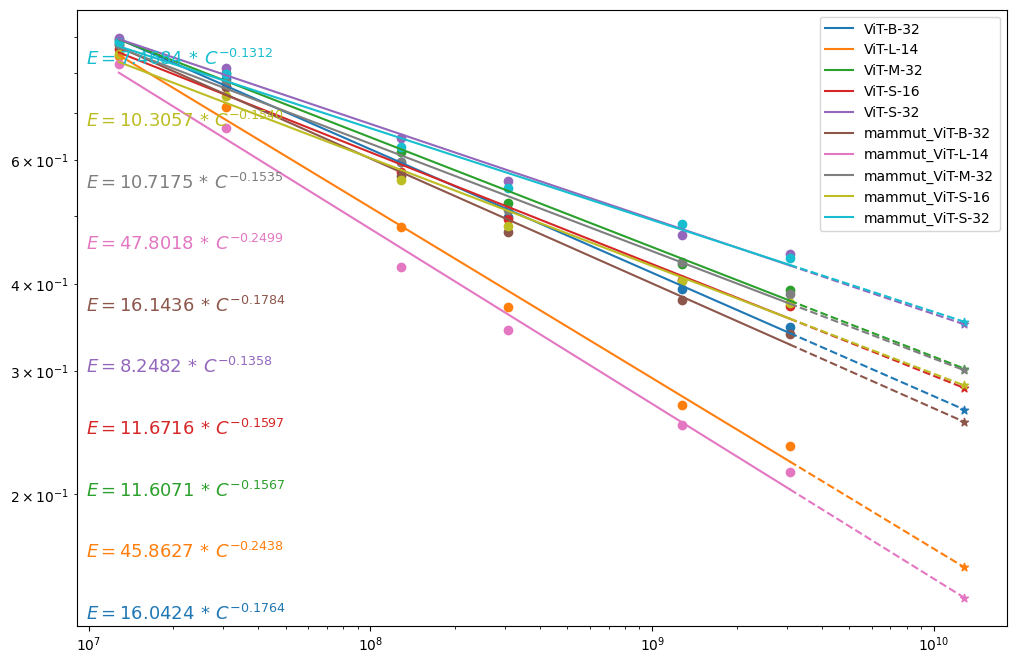

In [67]:
# make_fit_plot(decimal_table, metric_name='acc1', figsize = (12,8))

# model_type='L-14'
x_axis_scale='samples_seen_ID'
metric_type ='acc1'
cut_off=[2, None]
x_pred=[1.28e+10]
fig_size=(12, 8)


f = make_fit_plot(decimal_table, metric_type, figsize = fig_size, x_col=x_axis_scale, cut_off = cut_off, x_pred=x_pred)

# curve fit: total compute scale

In [10]:
# d = d[d.model=="ViT-S-32"]
# table_d = d.groupby()
# d["samples_seen_ID"] = d["samples_seen_scale"].apply(lambda x:x.split("_")[0])
# d.samples_seen_ID
metric =['acc1', 'acc5', 'image_retrieval_recall@5', 'text_retrieval_recall@5']

# table_d = d.groupby(["model", "gflops_total"])[metric].max()
table_d = d.groupby(["gflops_total", "model", "samples_seen_ID"])[metric].max()


# table_d = table_d.reset_index().T
table_d = table_d.reset_index()


# table_d = table_d.reset_index().set_index("samples_seen_ID").T

# table_d = table_d.pivot(index='samples_seen_ID', columns='model')

# table_d = table_d.pivot(index='gflops_total')

# order = '1.28M, 3M, 12.8M, 30M, 128M, 300M, 1.28B, 3B'
# order = order.split(', ')
# table_d = table_d.loc[order]

# order_model_columns = 'ViT-S-32 ViT-M-32 ViT-S-16 ViT-B-32 ViT-L-14'
# order_model_columns = order_model_columns.split(' ')

# FOR MAMMUT, PLUG IN, OTHERWISE, OUTCOMMENT
# order_model_columns = ['mammut_'+ model for model in order_model_columns]

display(table_d)

for m in metric:

# # order_model_columns

# # table_d = table_d[reversed(list(table_d.columns))]
    # print(m + '\n------------------')
    t = table_d[m]
    t = pd.DataFrame(t)
    t.header = [m]
    # display(table_d[m])
    
# table_d.columns = table_d["model"]
# [1.28M, 3M, 12.8M, 30M, 128M, 300M, 1.28B]

# [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9]

,gflops_total,model,samples_seen_ID,acc1,acc5,image_retrieval_recall@5,text_retrieval_recall@5
0,7.244800e+06,ViT-S-32,1.28M,0.01304,0.05028,0.019589,0.0314
1,1.273600e+07,ViT-M-32,1.28M,0.01396,0.05036,0.022068,0.0296
2,1.610240e+07,ViT-S-16,1.28M,0.02000,0.06950,0.029424,0.0406
3,1.738752e+07,ViT-S-32,3M,0.03032,0.09980,0.038139,0.0544
4,1.818880e+07,mammut_ViT-S-32,1.28M,0.01452,0.05212,0.019629,0.0296
5,1.891840e+07,ViT-B-32,1.28M,0.01352,0.04744,0.018510,0.0258
6,2.789120e+07,mammut_ViT-S-16,1.28M,0.02148,0.07108,0.028624,0.0418
7,2.880000e+07,mammut_ViT-M-32,1.28M,0.01388,0.05236,0.019029,0.0292
8,3.056640e+07,ViT-M-32,3M,0.03240,0.10296,0.038618,0.0546
9,3.499520e+07,mammut_ViT-B-32,1.28M,0.01440,0.05156,0.020109,0.0272


/tmp/ipykernel_32602/2197570869.py:41: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  t.header = [m]


/tmp/ipykernel_32602/2633479096.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  decimal_table[m].samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9, 3.072e+9]


Predictions for ViT-L-14: [6000000000000.0] 0.8649076253379521
Predictions for mammut_ViT-L-14: [6000000000000.0] 0.876004734885388


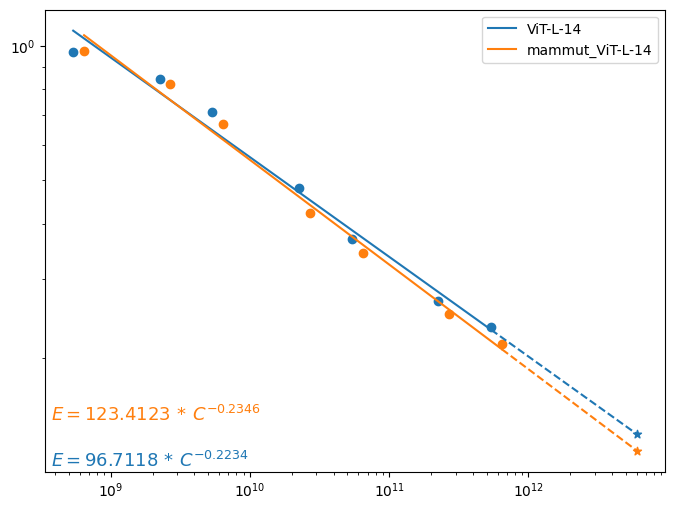

In [51]:
def plot_scale_via_model(table_d, model_type, x_axis_scale, metric_type, cut_off=[0, None], x_pred=[6e+12], fig_size=(8, 6)):
    table_model = table_d[table_d.model.str.contains(model_type)]

    table_model = table_model.pivot(index=x_axis_scale, columns='model')[[metric_type]]

    table_model = convert_table(table_model, [metric_type])

    f = make_fit_plot(table_model, metric_type, figsize = fig_size, x_col=x_axis_scale, cut_off = cut_off, x_pred=x_pred)



model_type='L-14'
x_axis_scale='gflops_total'
metric_type ='acc1'
cut_off=[2, None]
x_pred=[6e+12]
fig_size=(8, 6)

plot_scale_via_model(table_d, model_type, x_axis_scale, metric_type, cut_off, x_pred, fig_size)

# table_L_14
 


/tmp/ipykernel_32602/2633479096.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  decimal_table[m].samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9, 3.072e+9]


Predictions for ViT-B-32: [6000000000000.0] 0.839442422127751
Predictions for mammut_ViT-B-32: [6000000000000.0] 0.8330807322530268


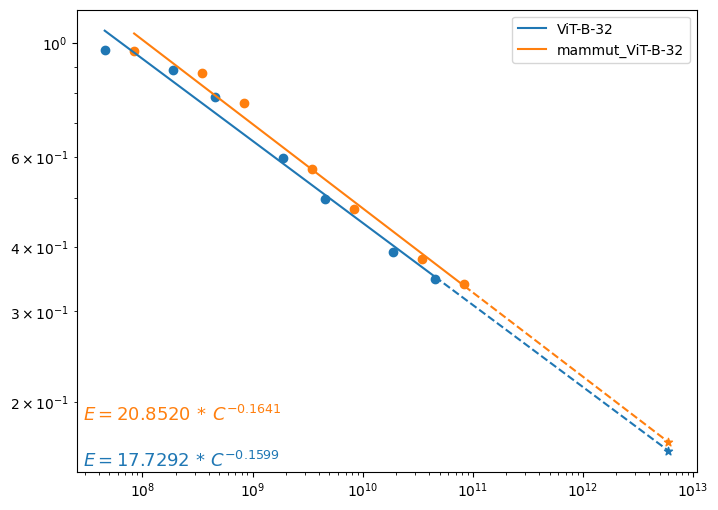

In [52]:
model_type='B-32'
x_axis_scale='gflops_total'
metric_type ='acc1'
cut_off=[2, None]
x_pred=[6e+12]
fig_size=(8, 6)

plot_scale_via_model(table_d, model_type, x_axis_scale, metric_type, cut_off, x_pred, fig_size)

/tmp/ipykernel_32602/2633479096.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  decimal_table[m].samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9, 3.072e+9]


Predictions for ViT-S-16: [6000000000000.0] 0.8279748047100357
Predictions for mammut_ViT-S-16: [6000000000000.0] 0.8125597105913017


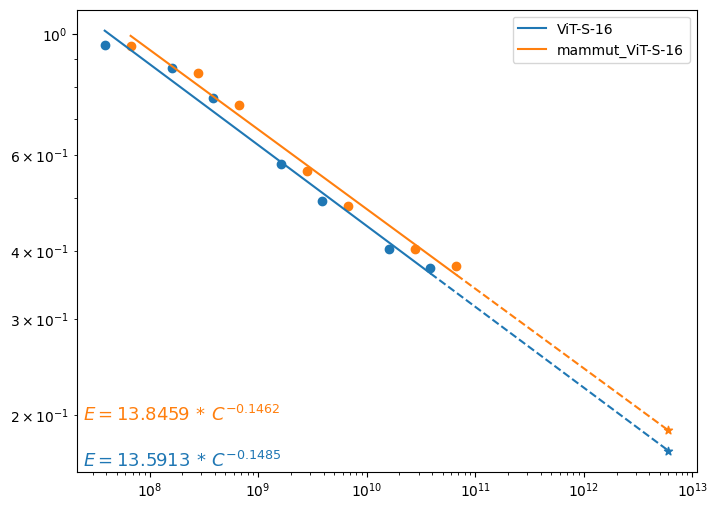

In [53]:
model_type='S-16'
x_axis_scale='gflops_total'
metric_type ='acc1'
cut_off=[2, None]
x_pred=[6e+12]
fig_size=(8, 6)

plot_scale_via_model(table_d, model_type, x_axis_scale, metric_type, cut_off, x_pred, fig_size)

/tmp/ipykernel_32602/2633479096.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  decimal_table[m].samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9, 3.072e+9]


Predictions for ViT-M-32: [6000000000000.0] 0.8175748858409146
Predictions for mammut_ViT-M-32: [6000000000000.0] 0.7979498813882075


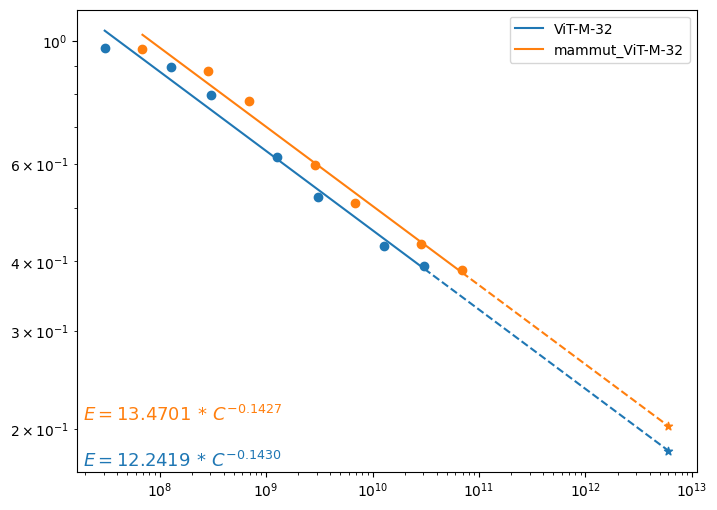

In [54]:
model_type='M-32'
x_axis_scale='gflops_total'
metric_type ='acc1'
cut_off=[2, None]
x_pred=[6e+12]
fig_size=(8, 6)

plot_scale_via_model(table_d, model_type, x_axis_scale, metric_type, cut_off, x_pred, fig_size)

/tmp/ipykernel_32602/2633479096.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  decimal_table[m].samples_seen_ID = [1.28e+6, 3.072e+6, 1.28e+7, 3.072e+7, 1.28e+8, 3.072e+8, 1.28e+9, 3.072e+9]


Predictions for ViT-S-32: [6000000000000.0] 0.8079315209317528
Predictions for mammut_ViT-S-32: [6000000000000.0] 0.7769210099650231


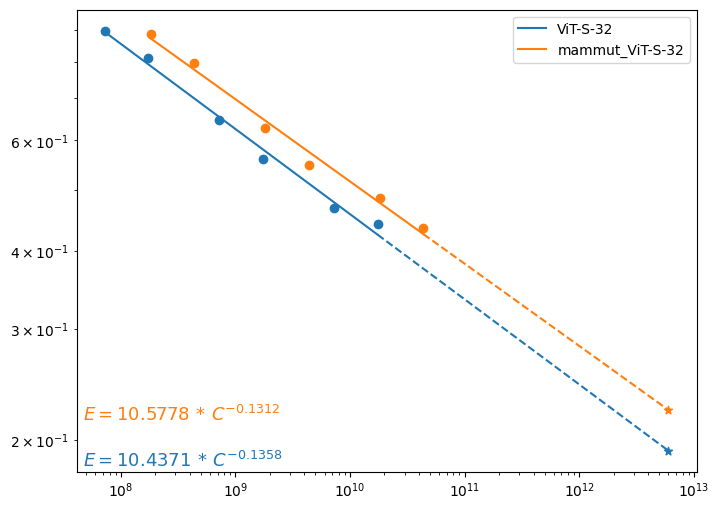

In [59]:
model_type='S-32'
x_axis_scale='gflops_total'
metric_type ='acc1'
cut_off=[4, None]
x_pred=[6e+12]
fig_size=(8, 6)

plot_scale_via_model(table_d, model_type, x_axis_scale, metric_type, cut_off, x_pred, fig_size)

# Downstream Task Learning curves

In [43]:
results = results_mammut
results["samples_seen_ID"] = results["samples_seen_scale"].apply(lambda x:x.split("_")[0])

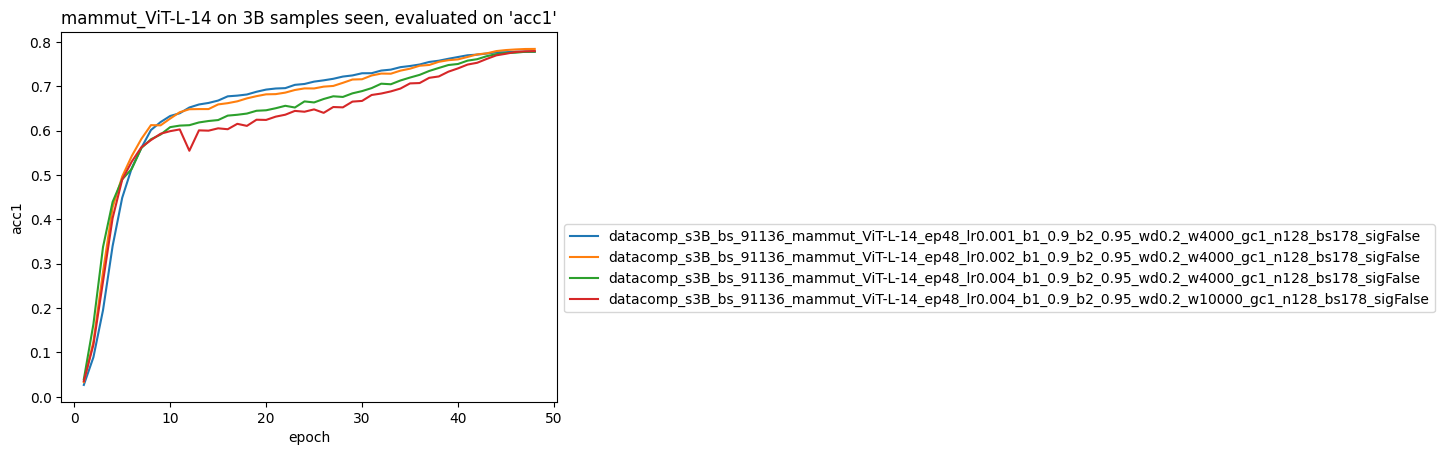

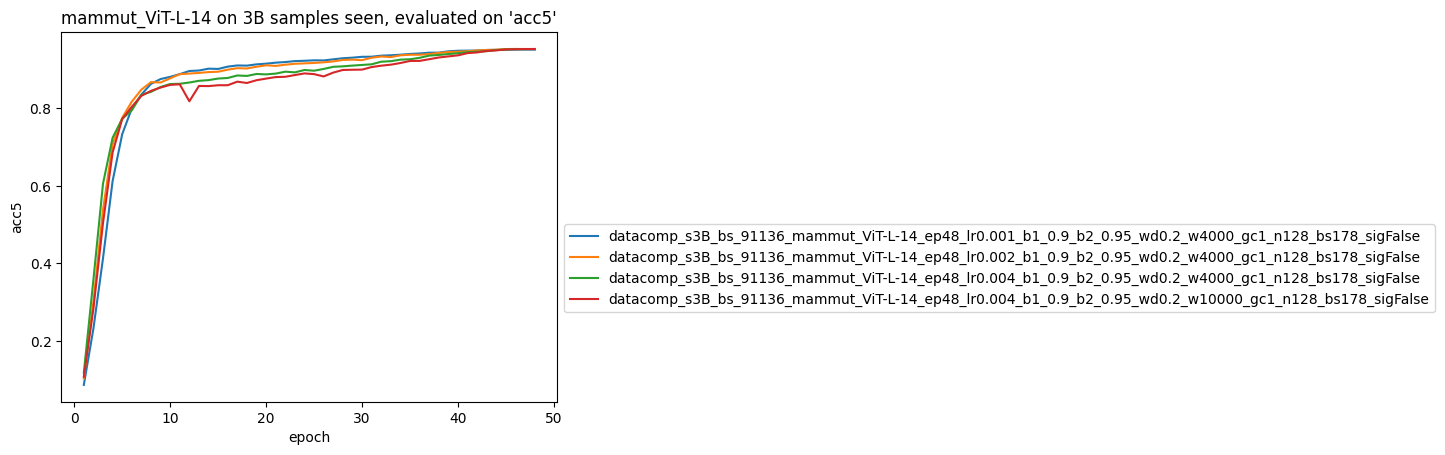

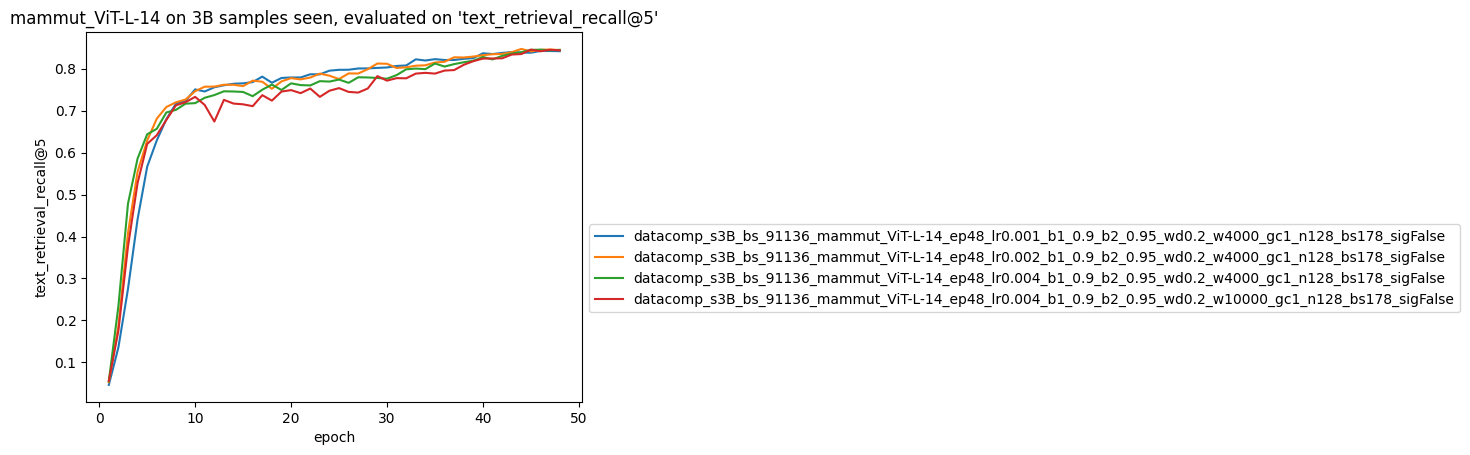

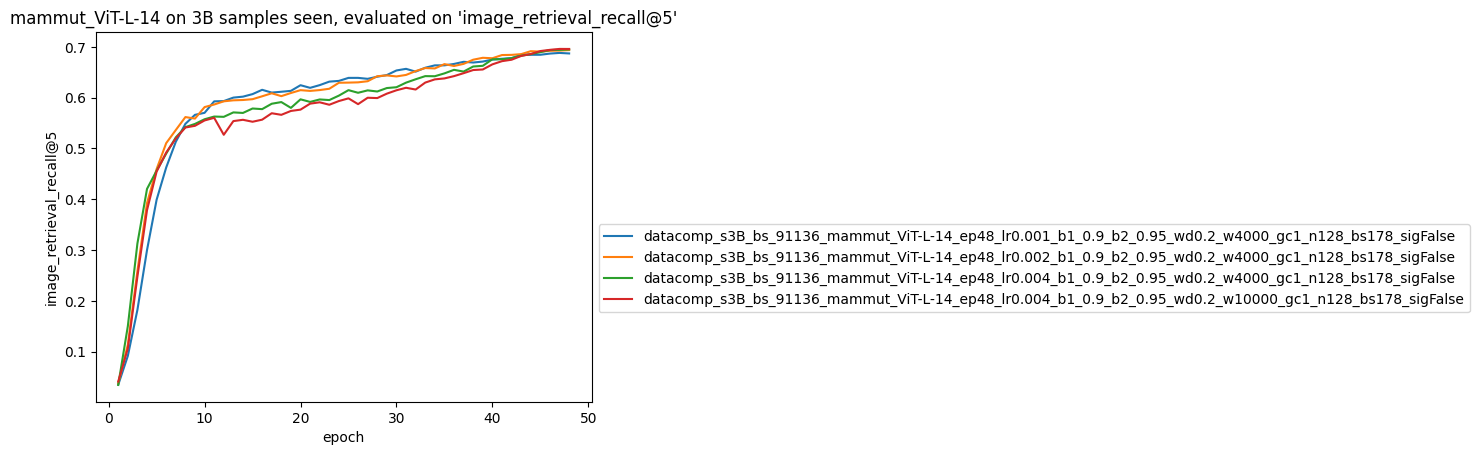

In [44]:
for model in ("mammut_ViT-L-14",):
    for metric in ("acc1", "acc5", "text_retrieval_recall@5", "image_retrieval_recall@5"):
        for samples_seen in ("3B", ):
            d = results
            d = d[(d.model == model) & (d.samples_seen_ID==samples_seen)]
            sns.lineplot(x="epoch", y=metric, data=d, hue="name")
            #d = d.sort_values(by='epoch')
            #d.plot(x='epoch', y=metric)
            plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{metric}'")
            plt.legend(bbox_to_anchor=(1,0.5))
            plt.show()

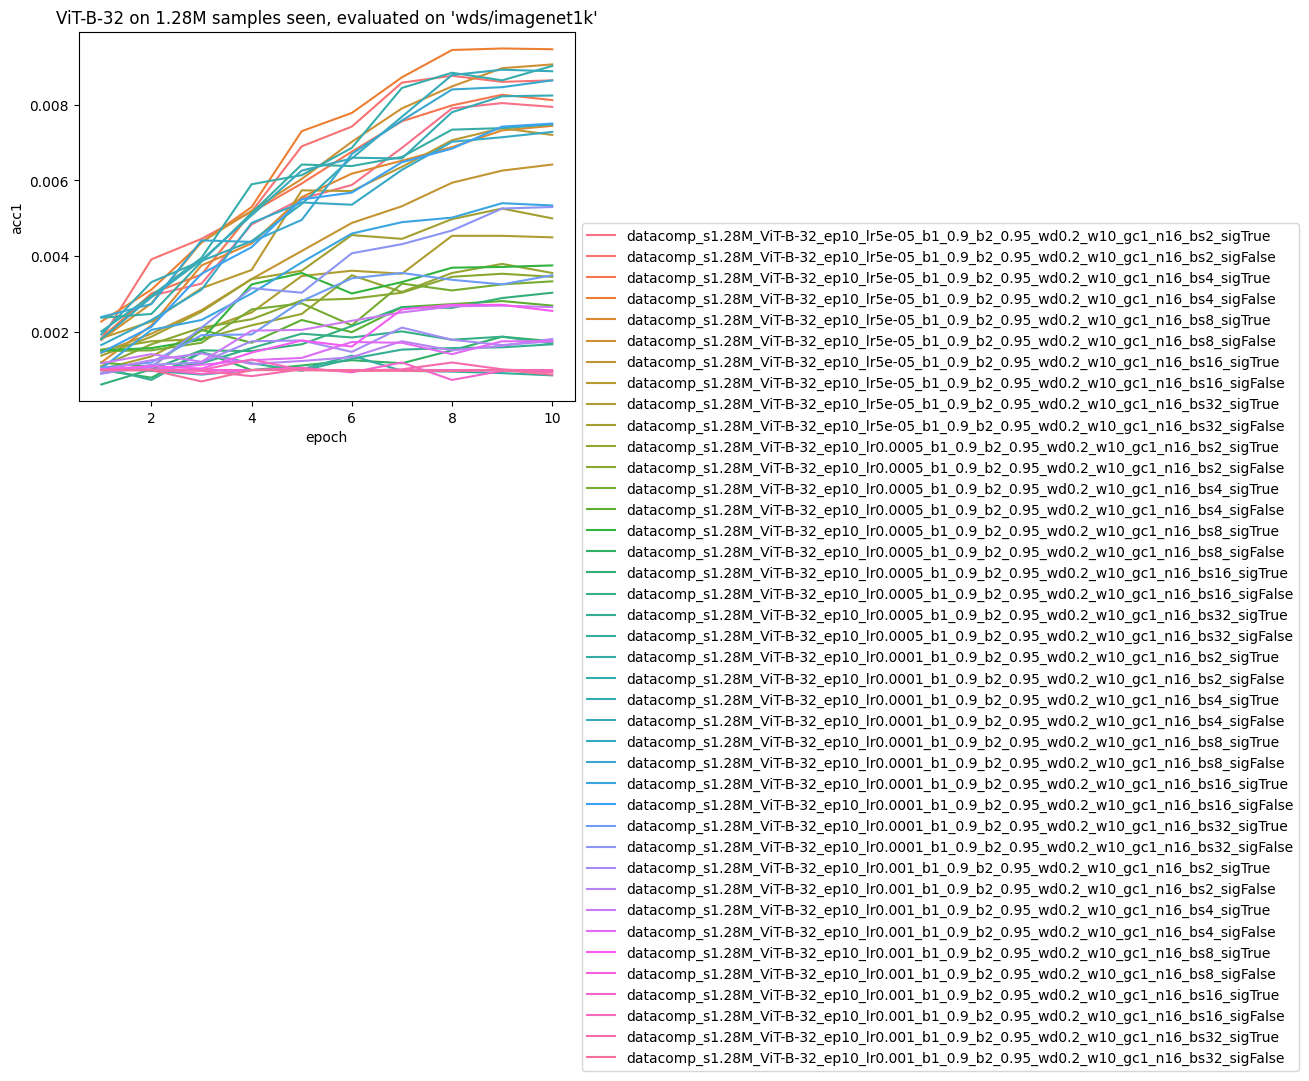

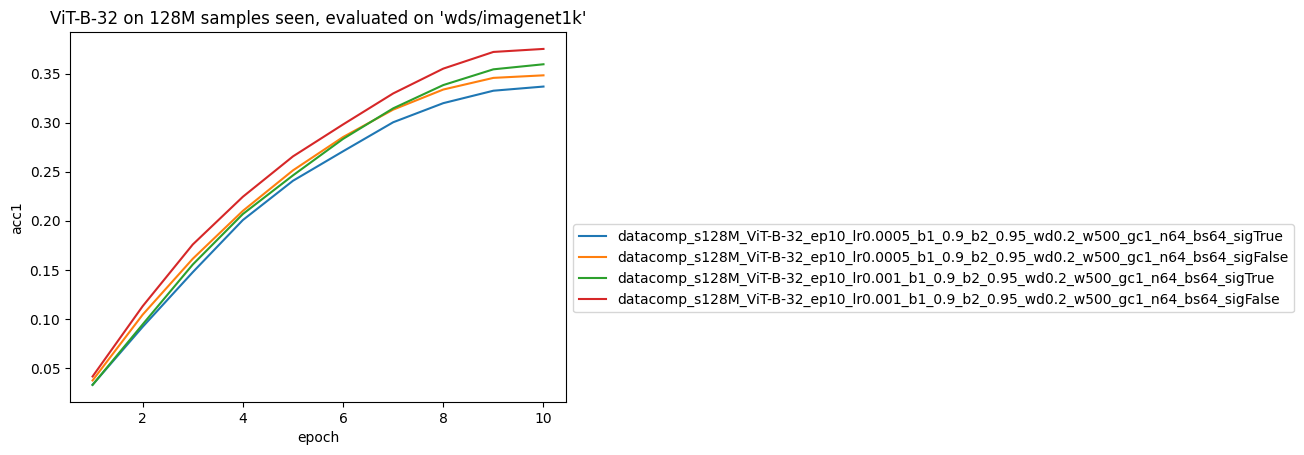

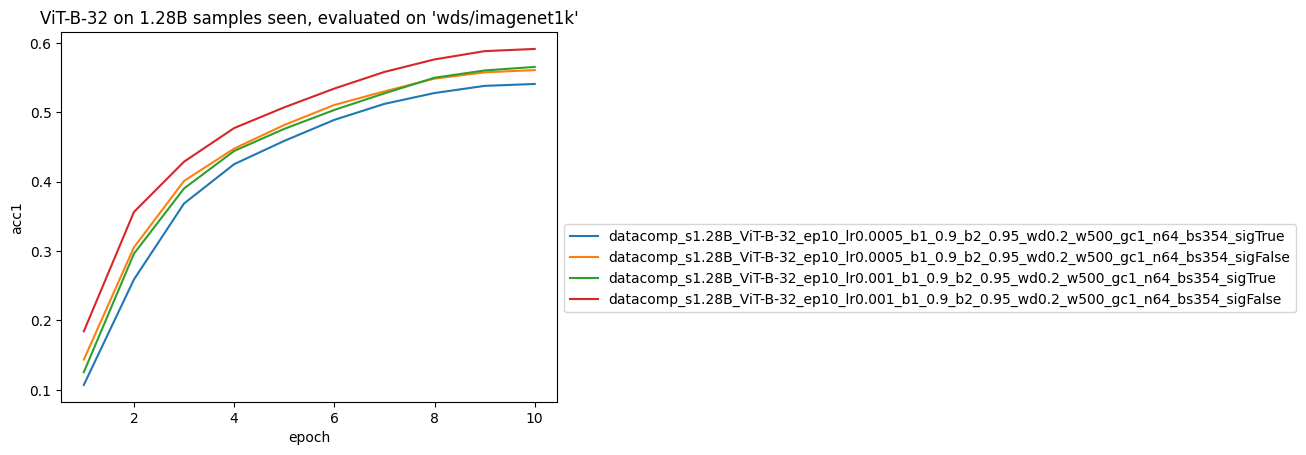

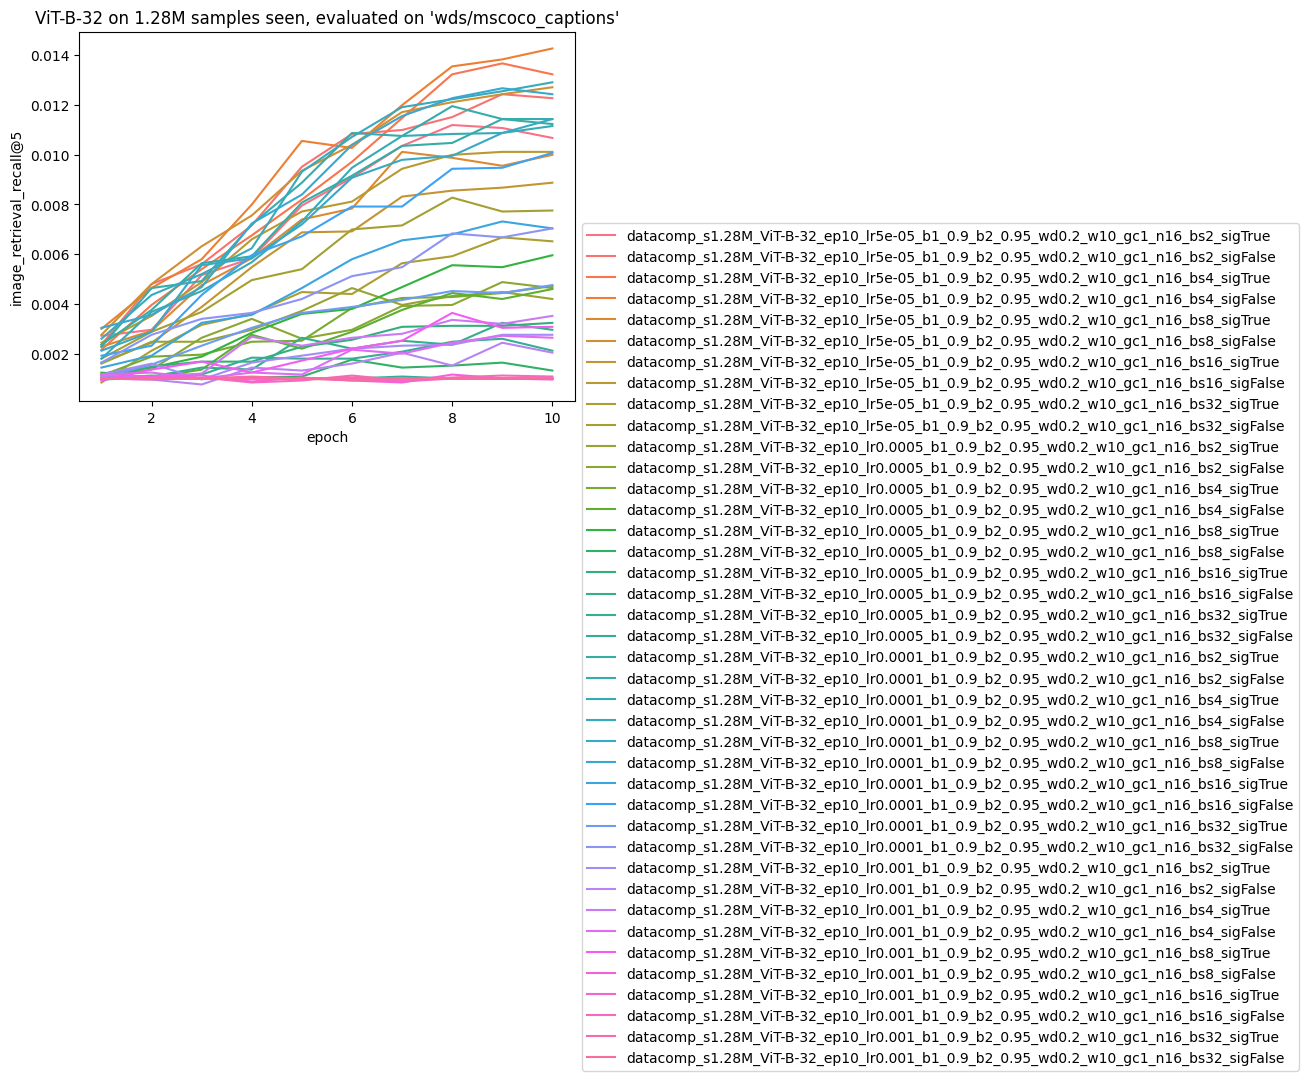

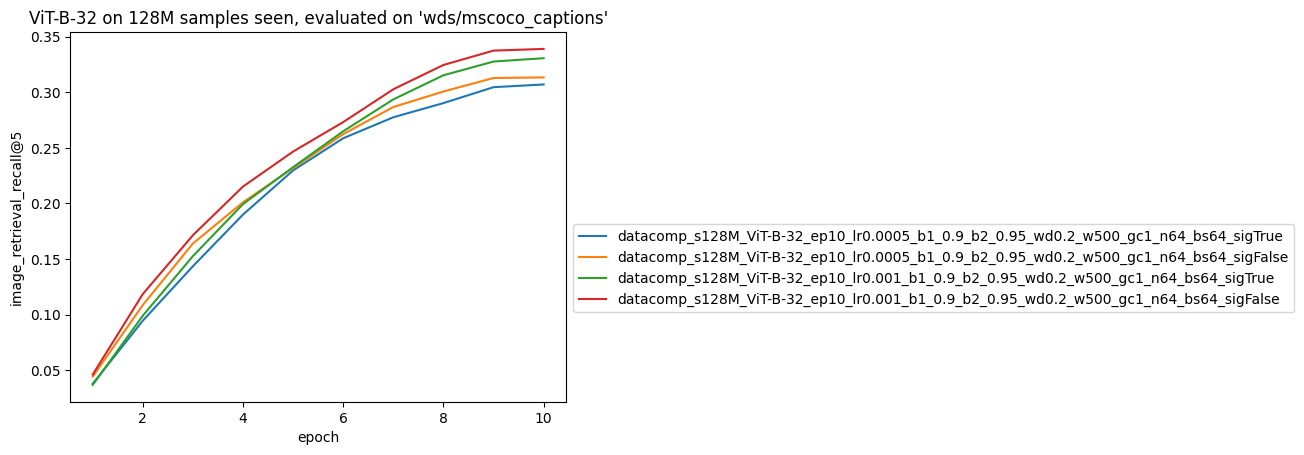

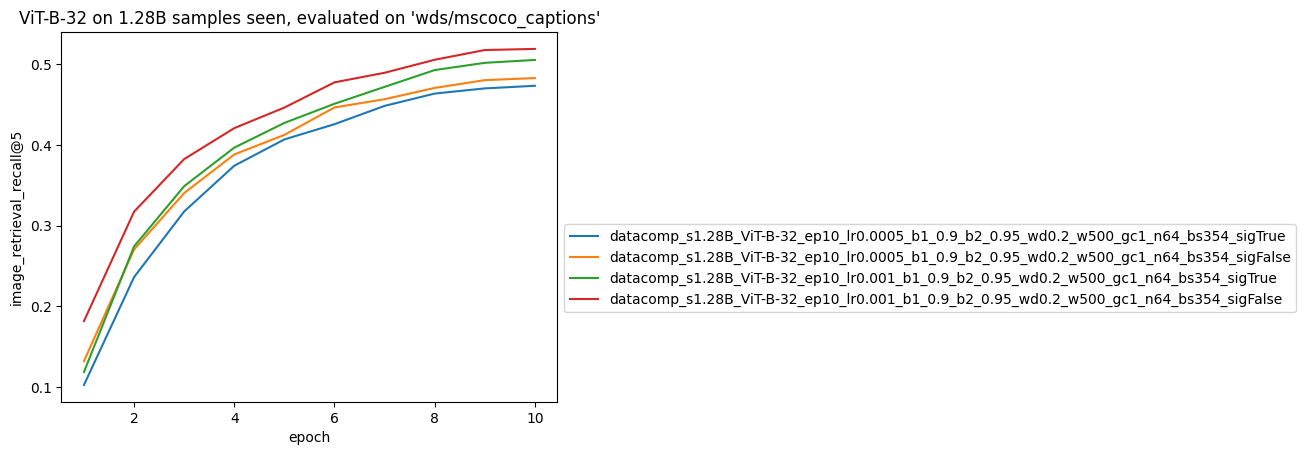

In [208]:
for model in ("ViT-B-32",):
    for (ds, metric) in ( ("wds/imagenet1k", "acc1"), ("wds/mscoco_captions", "image_retrieval_recall@5")):
        for samples_seen in ("1.28M", "128M", "1.28B"):
            d = results
            d = d[(d.model == model) & (d.samples_seen_scale==samples_seen) & (d.downstream_dataset==ds)]
            sns.lineplot(x="epoch", y=metric, data=d, hue="name")
            #d = d.sort_values(by='epoch')
            #d.plot(x='epoch', y=metric)
            plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
            plt.legend(bbox_to_anchor=(1,0.5))
            plt.show()

# Scaling curve

/tmp/ipykernel_1202/1975605851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["err"] = 1 - d[metric]


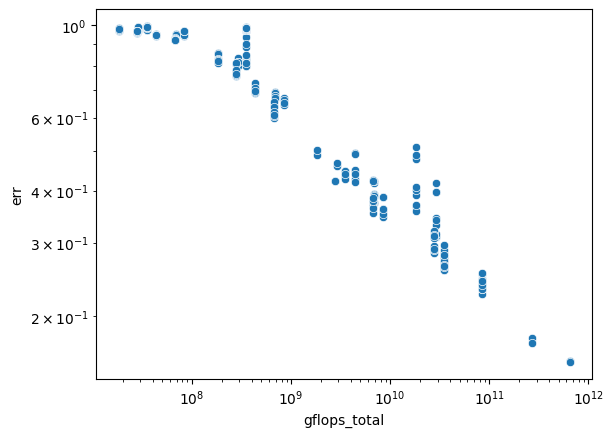

In [20]:
d = results[results.total_epochs==results.epoch]
# d = results[results.epoch=="latest"]
# ds = 'wds/imagenet1k'
# metric = 'acc1'
# metric = 'acc5'
# metric = 'image_retrieval_recall@5'
metric = 'text_retrieval_recall@5'
# d = d[d.downstream_dataset==ds]
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d)
plt.xscale("log")
plt.yscale("log")

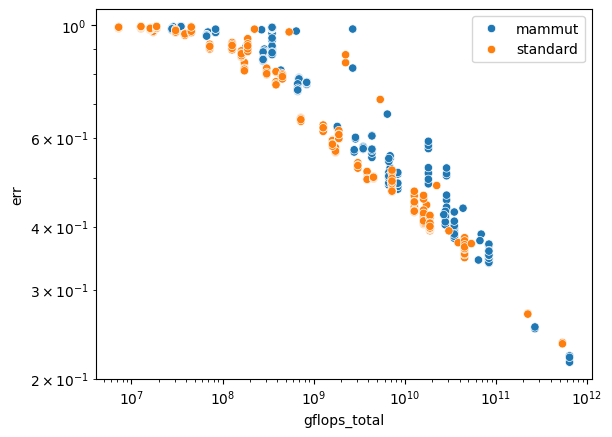

In [42]:
d_mammut = results_mammut[results_mammut.total_epochs==results_mammut.epoch]
d_standard = results_standard[results_standard.total_epochs==results_standard.epoch]

d = pd.concat([d_mammut, d_standard], axis=0)
# d = results[results.epoch=="latest"]
# ds = 'wds/imagenet1k'
metric = 'acc1'
# metric = 'acc5'
# metric = 'image_retrieval_recall@5'
# metric = 'text_retrieval_recall@5'


d['model_type'] = d['model'].apply(lambda x: 'mammut' if 'mammut' in x else 'standard')

# d = d[d.downstream_dataset==ds]
# for d in [d_mammut, d_standard]:
#     d["err"] = 1 - d[metric]
#     d["err"] = 1 - d[metric]
#     sns.scatterplot(x="gflops_total", y="err", data=d, )
    # plt.scatter(d["gflops_total"], d["err"])
    # plt.legend()
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d, hue='model_type')
# sns.scatterplot(x="gflops_total", y="err", data=d, hue='model')


plt.xscale("log")
plt.yscale("log")
plt.legend()

In [14]:
d[metric]

6       0.01050
16      0.00976
26      0.01306
36      0.01452
46      0.01224
56      0.01328
66      0.01000
76      0.01248
86      0.00776
96      0.01028
103     0.03056
115     0.03060
127     0.03168
139     0.03208
151     0.03210
163     0.03340
175     0.03090
187     0.03086
202     0.09212
212     0.09034
222     0.10794
232     0.10868
242     0.11384
252     0.11126
262     0.10764
272     0.11120
279     0.18718
291     0.18410
303     0.20310
315     0.20358
327     0.20124
339     0.19542
351     0.20068
363     0.20042
375     0.37228
395     0.36878
415     0.43350
439     0.43074
463     0.45214
487     0.44132
511     0.39408
535     0.39560
559     0.43400
583     0.43084
607     0.42956
627     0.42112
647     0.41006
667     0.49010
687     0.48994
707     0.47694
727     0.51420
747     0.51408
767     0.50380
792     0.01096
802     0.01202
812     0.01300
822     0.01388
832     0.00996
842     0.01194
852     0.00774
862     0.00876
872     0.00596
882     